<a href="https://colab.research.google.com/github/manjotmb20/Transfer-Learning/blob/master/Transferlearningdogvscat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras.applications import VGG16

Using TensorFlow backend.


In [0]:
conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(80,80,3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 6s 0us/step


In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0         
__________

In [0]:
pip install kaggle

In [0]:
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 95% 257M/271M [00:03<00:00, 60.6MB/s]
100% 271M/271M [00:03<00:00, 85.4MB/s]
 99% 539M/544M [00:07<00:00, 94.7MB/s]
100% 544M/544M [00:07<00:00, 80.4MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 52.6MB/s]


In [0]:
import zipfile
import os

In [0]:
os.listdir()

['.config',
 'test.zip',
 'kaggle.json',
 'train.zip',
 'sample_submission.csv',
 'sample_data']

In [0]:
zip_ref=zipfile.ZipFile('test.zip','r')
zip_ref.extractall()
zip_ref.close()

In [0]:
zip_ref=zipfile.ZipFile('train.zip','r')
zip_ref.extractall()
zip_ref.close()

In [0]:
path="../content"

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen=ImageDataGenerator(rescale=1./255)
batch_size=20

In [0]:
path="../content/train"
X = []
y = []
convert = lambda category : int(category == 'dog')
def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)
        img_array = cv2.imread(os.path.join(path,p))
        new_img_array = cv2.resize(img_array, dsize=(80,80))
        X.append(new_img_array)
        y.append(category)

In [0]:
import cv2
create_test_data(path)
X = np.array(X).reshape(-1, 80,80,3)
y = np.array(y)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X,y, test_size=0.2, random_state=1)

In [0]:
testpath="../content/test"
X_test=[]
id_line=[]
def create_test_data(path):
  for p in os.listdir(path):
    id_line.append(p.split(".")[0])
    img_array=cv2.imread(os.path.join(path,p))
    new_img_array=cv2.resize(img_array,dsize=(80,80))
    X_test.append(new_img_array)
create_test_data(testpath)
X_test=np.array(X_test).reshape(-1,80,80,3)

In [0]:
train_dir="../content/train"
validation_dir="../content/test"
test_dir="../content/test"

In [0]:
def extract_features(directory,Y,sample_count):
  features=np.zeros(shape=(sample_count,2,2,512))
  labels=np.zeros(shape=(sample_count))
  generator=datagen.flow(np.array(directory),Y,batch_size=batch_size)
  i=0
  for inputs_batch,labels_batch in generator:
    features_batch=conv_base.predict(inputs_batch)
    features[i*batch_size:(i+1)*batch_size]=features_batch
    labels[i*batch_size:(i+1)*batch_size]=labels_batch
    i+=1
    if i*batch_size>=sample_count:
      break
  return features,labels
train_features, train_labels = extract_features(X_train,Y_train,20000)
validation_features, validation_labels = extract_features(X_val,Y_val, 5000)

    

In [0]:
train_features = np.reshape(train_features, (20000, 2 * 2 * 512))
validation_features = np.reshape(validation_features, (5000, 2 * 2 * 512))

In [0]:
train_features.shape

(20000, 2048)

In [0]:
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Activation
from keras import optimizers

In [0]:
model=Sequential()
model.add(Dense(256,activation='relu',input_dim=2*2*512))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])
history=model.fit(train_features,train_labels,epochs=40,batch_size=20,validation_data=(validation_features,validation_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/40
20000/20000 [==============================] - 4s 188us/step - loss: 0.5896 - acc: 0.6750 - val_loss: 0.4754 - val_acc: 0.7716
Epoch 2/40
20000/20000 [==============================] - 3s 168us/step - loss: 0.4794 - acc: 0.7702 - val_loss: 0.4436 - val_acc: 0.7860
Epoch 3/40
20000/20000 [==============================] - 3s 165us/step - loss: 0.4505 - acc: 0.7895 - val_loss: 0.4314 - val_acc: 0.7956
Epoch 4/40
20000/20000 [==============================] - 3s 166us/step - loss: 0.4365 - acc: 0.7960 - val_loss: 0.4257 - val_acc: 0.7994
Epoch 5/40
20000/20000 [==============================] - 3s 165us/step - loss: 0.4287 - acc: 0.8010 - val_loss: 0.4187 - val_acc: 0.8038
Epoch 6/40
20000/20000 [==============================] - 3s 165us/step - loss: 0.4183 - acc: 0.8038 - val_loss: 0.4135 - val_acc: 0.8098
Epoch 7/40
20000/20000 [==============================] - 3s 165us/step - loss: 0.4114 - acc: 0.8090 - val_loss: 0.4132 - v

In [0]:
test_features, test_labels = extract_features(X_test, 12500)

In [0]:
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']


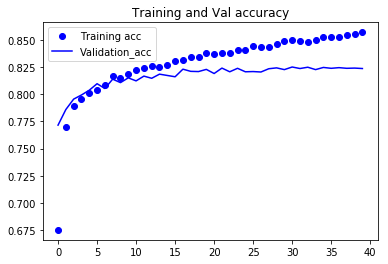

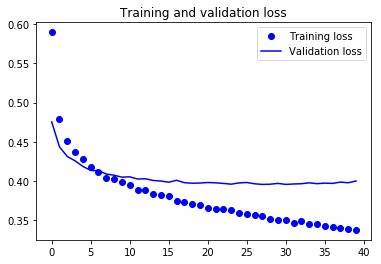

In [0]:
epochs=range(len(acc))
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation_acc')
plt.title('Training and Val accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



In [0]:
model=Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 15,239,489
Trainable params: 15,239,489
Non-trainable params: 0
_________________________________________________________________


In [0]:
conv_base.trainable=False

In [0]:
model.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(2048, 256) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(256, 1) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32_ref>]

In [0]:
X_train.shape

(20000, 80, 80, 3)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
validation_datagen=ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')


train_generator = train_datagen.flow(np.array(X_train), Y_train,batch_size=20)
validation_generator = validation_datagen.flow(np.array(X_val), Y_val, batch_size=20)

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [0]:
tlen=len(train_generator)
vlength=len(X_val)

In [0]:
vlength
tlen

1000

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=tlen,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=vlength)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
1000/1000 [==============================] - 195s 195ms/step - loss: 0.5543 - acc: 0.7147 - val_loss: 0.5056 - val_acc: 0.7514
Epoch 2/20
1000/1000 [==============================] - 191s 191ms/step - loss: 0.4832 - acc: 0.7675 - val_loss: 0.4739 - val_acc: 0.7714
Epoch 3/20
1000/1000 [==============================] - 191s 191ms/step - loss: 0.4613 - acc: 0.7770 - val_loss: 0.4591 - val_acc: 0.7816
Epoch 4/20
1000/1000 [==============================] - 191s 191ms/step - loss: 0.4516 - acc: 0.7892 - val_loss: 0.4528 - val_acc: 0.7839
Epoch 5/20
1000/1000 [==============================] - 192s 192ms/step - loss: 0.4431 - acc: 0.7906 - val_loss: 0.4474 - val_acc: 0.7875
Epoch 6/20
1000/1000 [==============================] - 191s 191ms/step - loss: 0.4424 - acc: 0.7894 - val_loss: 0.4392 - val_acc: 0.7932
Epoch 7/20
1000/1000 [==============================] - 191s 191ms/step - loss: 0.4357 - acc: 0.7940 - val_loss: 0.4380 - va

In [0]:
import pandas as pd

In [0]:
testpath="../content/test"
X_test=[]
id_line=[]
def create_test_data(path):
  for p in os.listdir(path):
    id_line.append(p.split(".")[0])
    img_array=cv2.imread(os.path.join(path,p))
    new_img_array=cv2.resize(img_array,dsize=(80,80))
    X_test.append(new_img_array)
create_test_data(testpath)
X_test=np.array(X_test).reshape(-1,80,80,3)
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = validation_datagen.flow(np.array(X_test), batch_size=1)
predictions = model.predict(X_test)
predicted_val = [int(round(p[0])) for p in predictions]
submission_df = {'id':id_line, 'label':predicted_val}
answer=pd.DataFrame(submission_df)
answer.to_csv("submissiondog.csv", index=False)

In [0]:
X_test.shape

(12500, 80, 80, 3)